In [1]:
!pip install seaborn
try:
    import pymc as pm # For MCMC
except:
    !pip install pymc
    import pymc as pm
try:
    import arviz as az # For MCMC package
except:
    !pip install arviz
    import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
try:
    import corner
except:
    !pip install corner
    import corner

print(pm.__version__)

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


5.15.0


## Importing data

In [57]:
import pandas as pd

file_path = 'datasets/Donor1_CD4_Genes.csv'

df1 = pd.read_csv(file_path)


           Unnamed: 0  MT-TF  MT-RNR1  MT-TV  MT-RNR2  MT-TL1  MT-ND1  MT-TI  \
0  AAACCTGCAAACTGTC.1      0        6      0       60       0      12      0   
1  AAACCTGCACAGCGTC.1      0        2      0       21       0       8      0   
2  AAACGGGAGACTGGGT.1      0       19      0       84       0       7      0   
3  AAACGGGAGGTGTTAA.1      0       27      0      115       0       3      0   
4  AAACGGGCATGGGACA.1      0       43      1      119       0       6      0   

   MT-TQ  MT-TM  ...  MT-TH  MT-TS2  MT-TL2  MT-ND5  MT-ND6  MT-TE  MT-CYB  \
0      0      0  ...      0       0       0       7       7      0      20   
1      0      0  ...      0       0       0       6       1      0      17   
2      0      0  ...      0       0       0       7       0      0      15   
3      0      0  ...      0       0       0       6       3      0      14   
4      0      0  ...      0       0       0       2       0      0       7   

   MT-TT  MT-TP  non-MT  
0      0      0    1250 

### I only need 13 proteins, df2 

In [68]:
file_path = 'datasets/mt_genes_metadata.csv'

dfmeta = pd.read_csv(file_path)


protein_coding_genes = dfmeta[dfmeta['gene_type'] == 'protein_coding']
protein_names = protein_coding_genes['gene_name'].tolist()
tRNA_coding_genes = dfmeta[dfmeta['gene_type']=='Mt_tRNA']
tRNA_names = tRNA_coding_genes['gene_name'].tolist()
rRNA_coding_genes = dfmeta[dfmeta['gene_type']=='Mt_rRNA']
rRNA_names = rRNA_coding_genes['gene_name'].tolist()

umi = df1["non-MT"]
df2 = pd.DataFrame([df1[i] for i in protein_names]).T

print(df2.head)

<bound method NDFrame.head of       MT-ND1  MT-ND2  MT-CO1  MT-CO2  MT-ATP8  MT-ATP6  MT-CO3  MT-ND3  \
0         12       3      23      53       34        3      38       6   
1          8       4      24      35       10        2      34       3   
2          7       2      16      30        8        1      19       6   
3          3       2      25      23       14        5      23       2   
4          6       3       6      26       14        1      11       4   
...      ...     ...     ...     ...      ...      ...     ...     ...   
2883       4       0      20      15       11        3      11       2   
2884       2       5      13      28       12        2      18       6   
2885       5       0      10      22       13        1      14       4   
2886       6      12      36      45       19        2      40       5   
2887       7       1       9      24       11        0      22       1   

      MT-ND4L  MT-ND4  MT-ND5  MT-ND6  MT-CYB  
0          20       5       7    

### ***A suggestion about the dataframe: genes are columns and cells are rows, rest of my code will strictly follow this way***

---


## Next step, normalisation

### a function: normiz
normally we would expect the normalization to be \

 row(cells) / umi correponding * some number \
 \
I *prefer* taking the some number to be norm of the umi \
so an optional parameter somenumber is there. 

In [87]:
def normiz(df,umi,somenumber = np.linalg.norm(umi)):
    df1 = df.T
    norm = np.linalg.norm(umi)
    print(norm)
    umi1 = umi/somenumber
    for i in range(len(umi1)):
        df1[i] = df1[i] / umi1[i]
    return df1.T

In [97]:
normiz(df2,umi)

250070.22420512204


,MT-ND1,MT-ND2,MT-CO1,MT-CO2,MT-ATP8,MT-ATP6,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB
0,2400.674152,600.168538,4601.292125,10602.977506,6801.910098,600.168538,7602.134816,1200.337076,4001.123587,1000.280897,1400.393256,1400.393256,4001.123587
1,837.405523,418.702761,2512.216568,3663.649162,1046.756903,209.351381,3558.973471,314.027071,1570.135355,732.729832,628.054142,104.675690,1779.486736
2,651.952167,186.272048,1490.176383,2794.080717,745.088191,93.136024,1769.584454,558.816143,1862.720478,279.408072,651.952167,0.000000,1397.040359
3,305.460372,203.640248,2545.503097,2341.862849,1425.481734,509.100619,2341.862849,203.640248,1323.661610,407.280495,610.920743,305.460372,1425.481734
4,369.561908,184.780954,369.561908,1601.434933,862.311118,61.593651,677.530164,246.374605,862.311118,0.000000,123.187303,0.000000,431.155559
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2883,323.088145,0.000000,1615.440725,1211.580544,888.492399,242.316109,888.492399,161.544072,403.860181,161.544072,242.316109,0.000000,323.088145
2884,171.046665,427.616662,1111.803322,2394.653310,1026.279990,171.046665,1539.419985,513.139995,1197.326655,171.046665,171.046665,85.523332,684.186660
2885,278.103007,0.000000,556.206015,1223.653232,723.067819,55.620601,778.688421,222.482406,333.723609,389.344210,278.103007,55.620601,1112.412029
2886,282.671693,565.343386,1696.030157,2120.037696,895.127027,94.223898,1884.477952,235.559744,942.238976,376.895590,329.783642,0.000000,1743.142105


### Function of plotting the mean-var scatter

In [76]:
def meanvarplot(seq1):
    seq = seq1.T
    list_mean = [np.mean(seq.iloc[i]) for i in range(13)]
    list_var = [np.var(seq.iloc[i]) for i in range(13)]
    x = np.linspace(0,min(max(list_mean),max(list_var)),num = 1000)
    plt.plot(x,x)
    plt.scatter(list_mean, list_var)
    plt.show()
    print(list_var)
    print(list_mean)

250070.22420512204


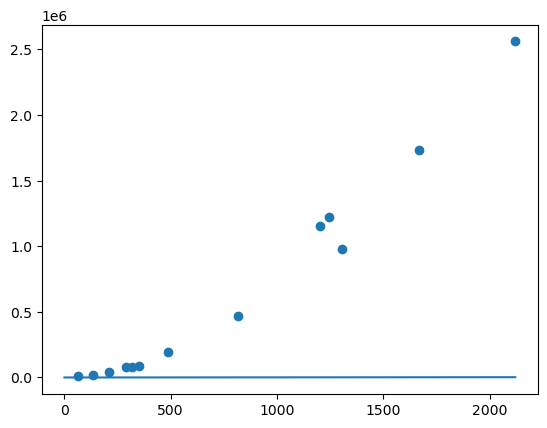

[197516.81753114882, 82218.14966938939, 1221408.3269125617, 2560068.8128141835, 1152600.1028193296, 20077.98207445609, 1732083.4918172525, 89939.2350333792, 471527.07319675357, 42848.96457824826, 81226.92123084699, 11699.042495722777, 977378.9237283919]
[488.7334062974924, 289.5180470360056, 1244.2397266879382, 2119.8521536797325, 1202.526820278621, 132.84329662468247, 1665.6717197338446, 349.19131182141916, 814.0877795718288, 208.09735318701775, 317.4216246808961, 65.28457339684515, 1302.940113074823]


In [96]:
meanvarplot(normiz(df2,umi))

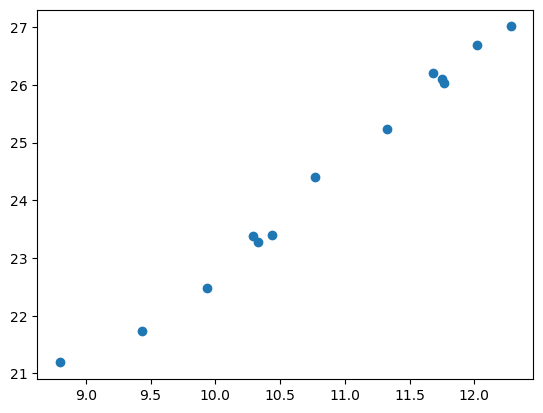

In [82]:
y = [39405502178.874176, 14270050297.713615, 215355647899.84335, 539331414712.78564, 239734538779.75415, 2747234578.422771, 394348531643.9634, 14472016525.325699, 91730867514.77098, 5754079977.802822, 12961089066.25124, 1596013212.4993975, 204012584253.58527]
x = [47630.013913849674, 29529.369527593317, 126661.54897436462, 215709.66710226206, 118022.10441414938, 12465.609550242913, 165462.9110493637, 34138.95923555267, 82932.81850558078, 20593.452077464488, 30539.072451652246, 6644.006650370145, 129042.84368275816]
plt.scatter(np.log(x),np.log(y))

250070.22420512204


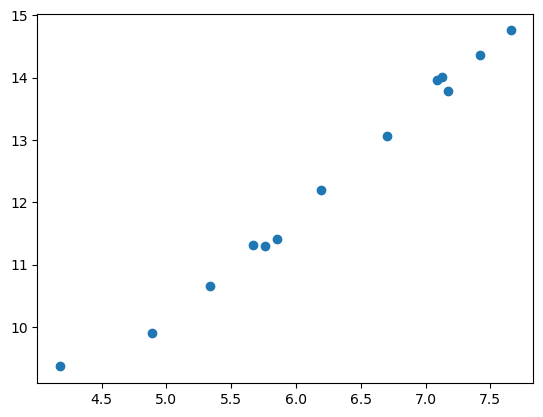

In [102]:
df3 = normiz(df2,umi)
df4 = df3.T
tri_mean = [np.mean(df4.iloc[i]) for i in range(13)]
tri_var = [np.var(df4.iloc[i]) for i in range(13)]
x = tri_mean
y = tri_var
plt.scatter(np.log(x),np.log(y))